In [1]:
from SignalProcessing import RangeCompression,DopplerProcessing,CFAR, Clustering
import Dataloader
import Plot
import numpy as np
from mmwave import dsp

In [2]:
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns; 
from matplotlib.colors import  LogNorm
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
from scipy import ndimage
from PIL import Image, ImageFilter
from scipy.ndimage import convolve1d

from operator import itemgetter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
no_reflector = "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin"
best_restult = "felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin"
munkholm = "felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin"

In [4]:
#raw_data = Dataloader.ReadData(no_reflector)

In [5]:
#data_IF =Dataloader.LoadData("best_restult.npy")
data_IF =Dataloader.LoadData("best_restult.npy")

In [105]:
old=  RangeCompression.RangeCompression(data_IF[100,0],axis=1)
old, _ = DopplerProcessing.DopplerProcessing(old, axis=0,isClutterRemoval=True, removeArtifacts=False)
old= np.abs(old)
#old[np.nonzero(old >4*np.mean(old[:,50]))] = 1e-10



In [32]:
range_cube =  RangeCompression.RangeCompression(data_IF[450,0],axis=1)

In [90]:
linear, mag = DopplerProcessing.DopplerProcessing(range_cube, axis=0,isClutterRemoval=True,removeArtifacts=False)

In [125]:
doppler_map = np.abs(linear)
doppler_map[np.nonzero(old >4*np.mean(old[:,50]))] =1e-10

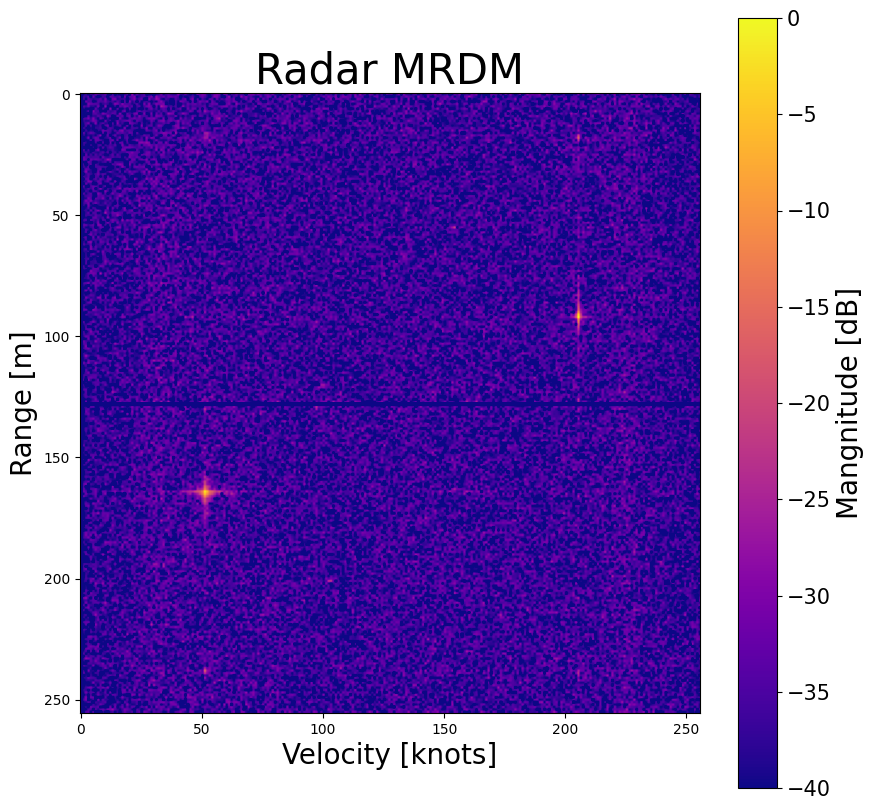

In [126]:
Plot.Plot(np.abs(old),vmin=-40)

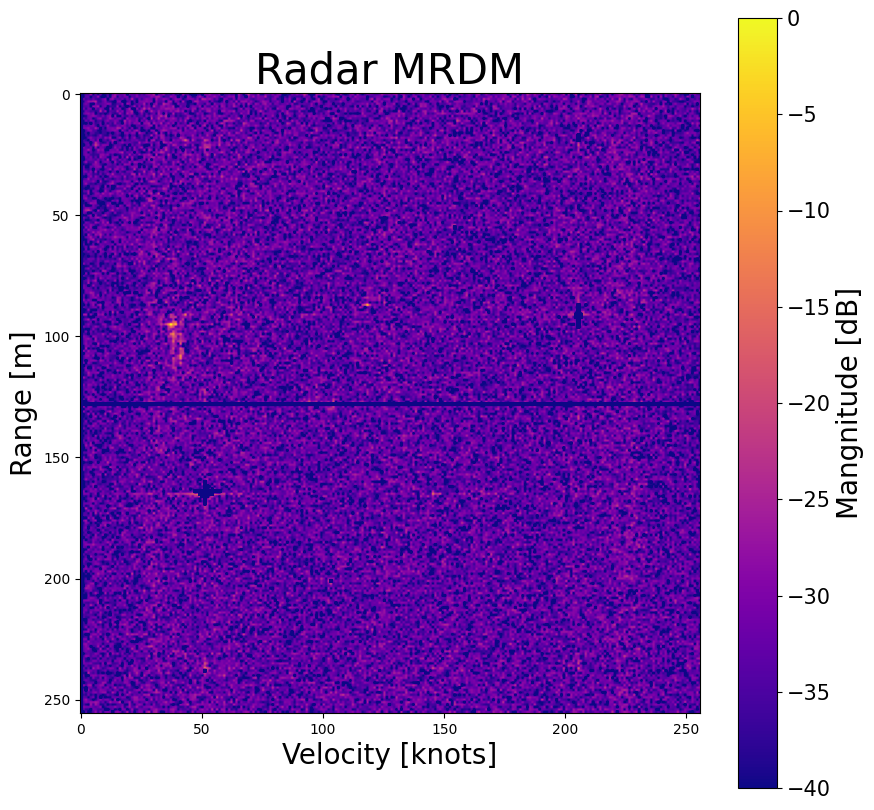

In [127]:
Plot.Plot(np.abs(doppler_map),vmin=-40)

In [108]:
CFAR_plot =CFAR.CA_CFAR_2D(np.abs(doppler_map))

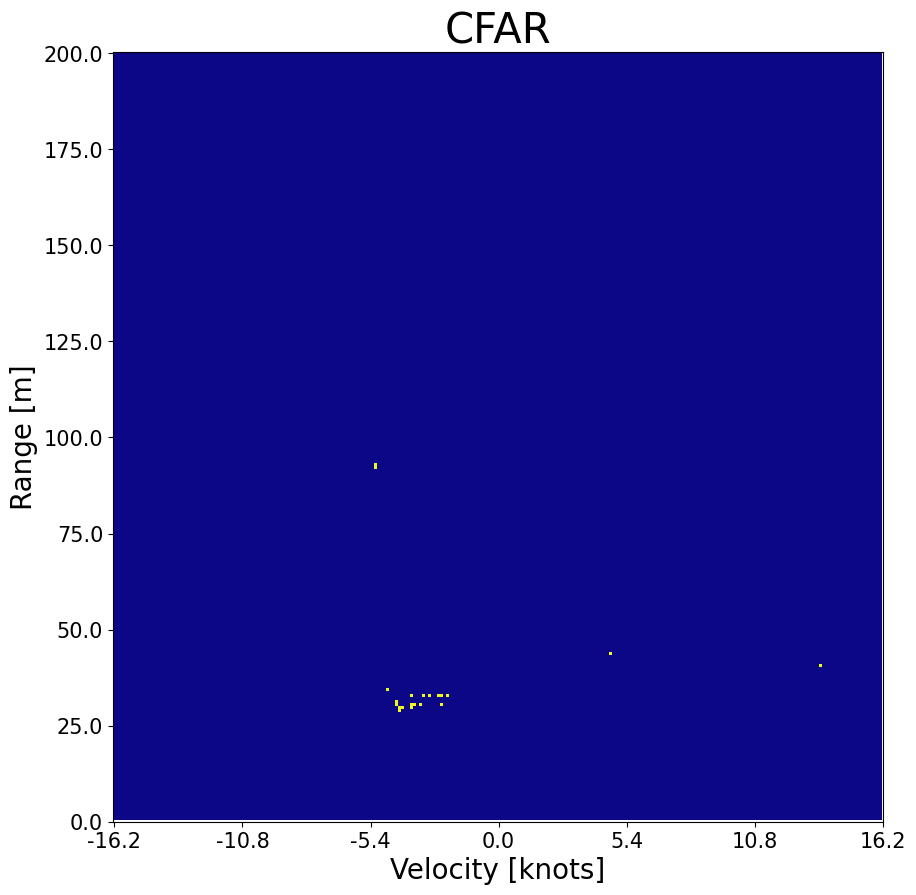

In [109]:
Plot.PlotCFAR(CFAR_plot)

In [12]:
from scipy.ndimage import convolve

In [13]:
def P_avg(P,N):
    return P
def alpha(N,P_FA):
    return(P_FA**(-1/N)-1)

def estimated_teshold(alpha,P):
    return alpha*np.abs(P)


def CFAR_1D(data, guard_cells, training_cells, PFA):
    
    
    window_size = guard_cells + training_cells
    
    window_area = (2*window_size+1)**2
    training_area = training_cells*2
    a = alpha(training_area, PFA)

    kernel = np.ones((1 + (2 * guard_cells) + (2 * training_cells)), dtype=data.dtype)
    kernel[training_cells:training_cells + (2 * guard_cells) + 1] = 0
    
    res = convolve1d(data.copy(), kernel, mode='wrap')
    
    
    ret = (np.abs(data)>estimated_teshold(a,res))

    
    

    
    
            
    return ret,data*ret
                
                
    

            
  

In [110]:
data_cfar,P = CFAR_1D(doppler_map.copy(), 4, 8, 0.01)

In [128]:
P

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [111]:
weight = 0.99
doppler_resolution = 0.236*3.6
use_elevation = False
custom_distance = lambda obj1, obj2: \
        (obj1[3] - obj2[3]) ** 2 + \
        (obj1[4] - obj2[4]) ** 2 + \
        use_elevation * (obj1[5] - obj2[5]) ** 2 + \
        weight * ((obj1[1] - obj2[1]) * doppler_resolution) ** 2

In [205]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
feature_image=np.reshape(P, [-1,1])
print(feature_image.shape)
db = DBSCAN(eps=0.01, min_samples=4,n_jobs=-1).fit(feature_image)
labels = db.labels_



(65536, 1)


In [206]:
db.n_features_in_

1

In [207]:
db.feature_names_in_

AttributeError: 'DBSCAN' object has no attribute 'feature_names_in_'

In [208]:
np.reshape(labels, [256, 256])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

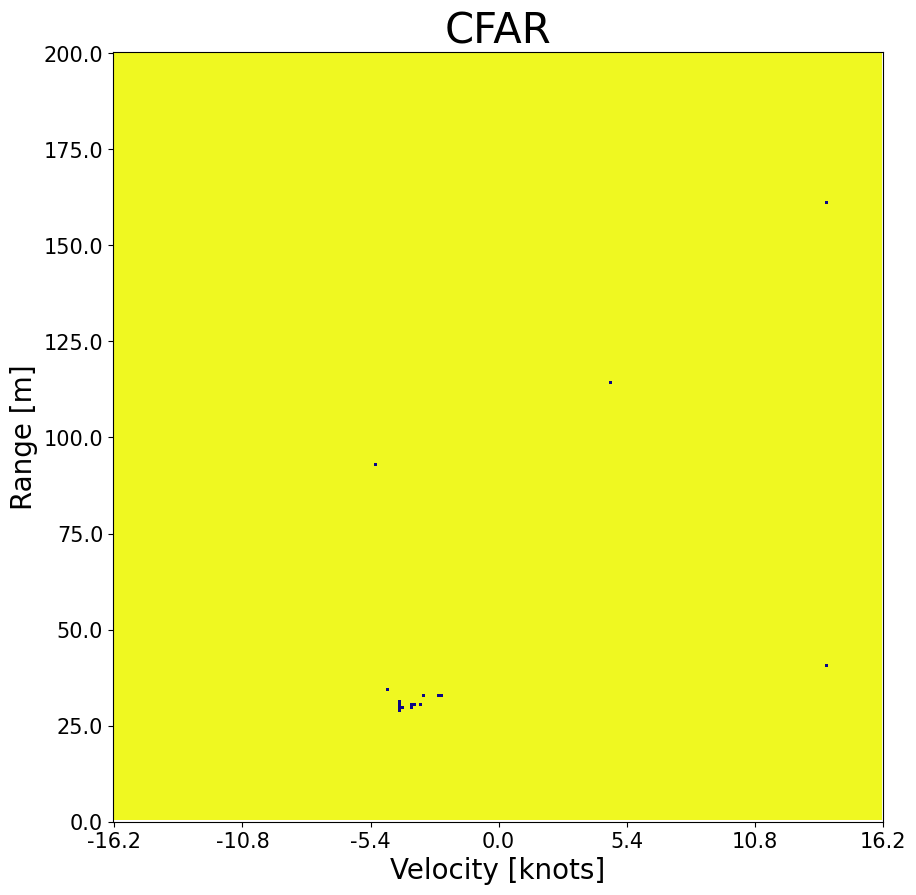

In [209]:
Plot.PlotCFAR(np.reshape(labels, [256, 256]))

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

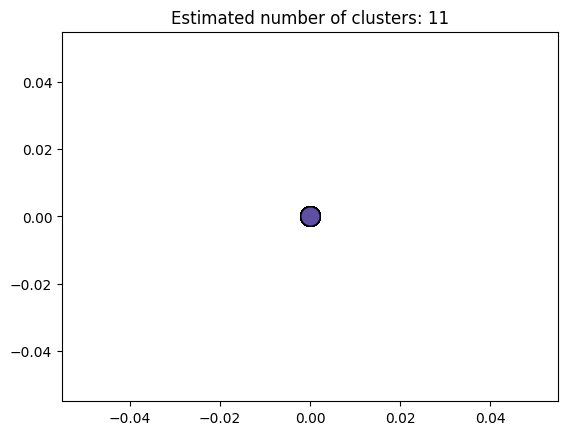

In [155]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
print(core_samples_mask)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = P[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = P[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

[0]


In [152]:
cluster

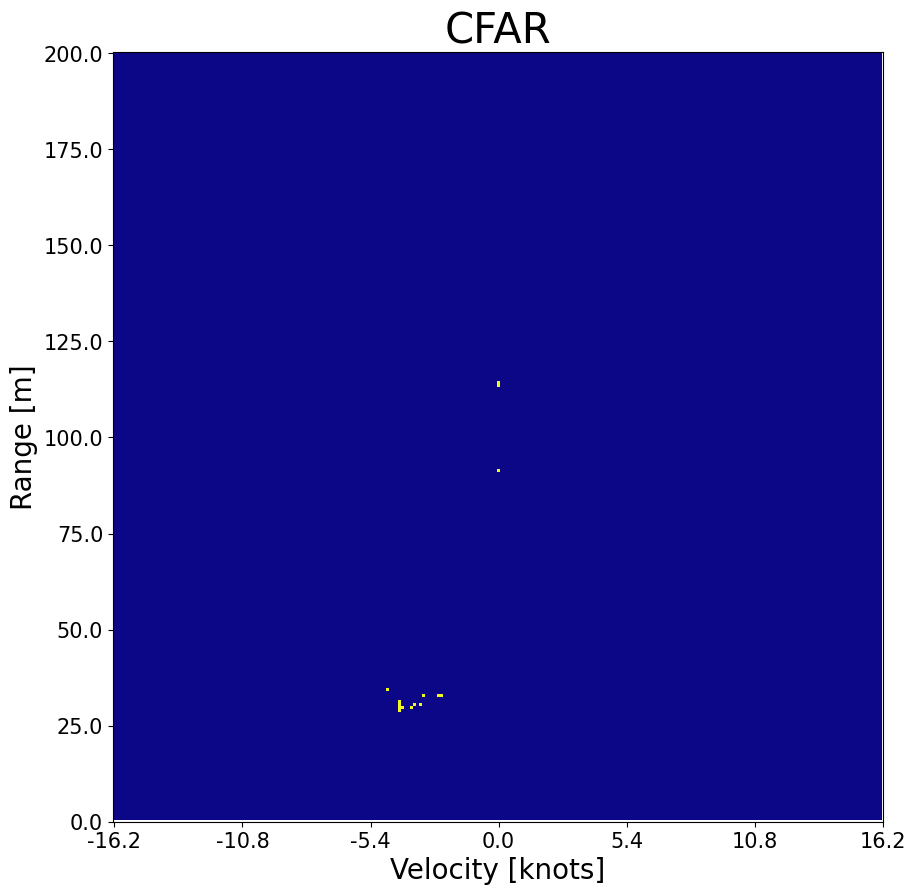

In [142]:

Plot.PlotCFAR(data_cfar)

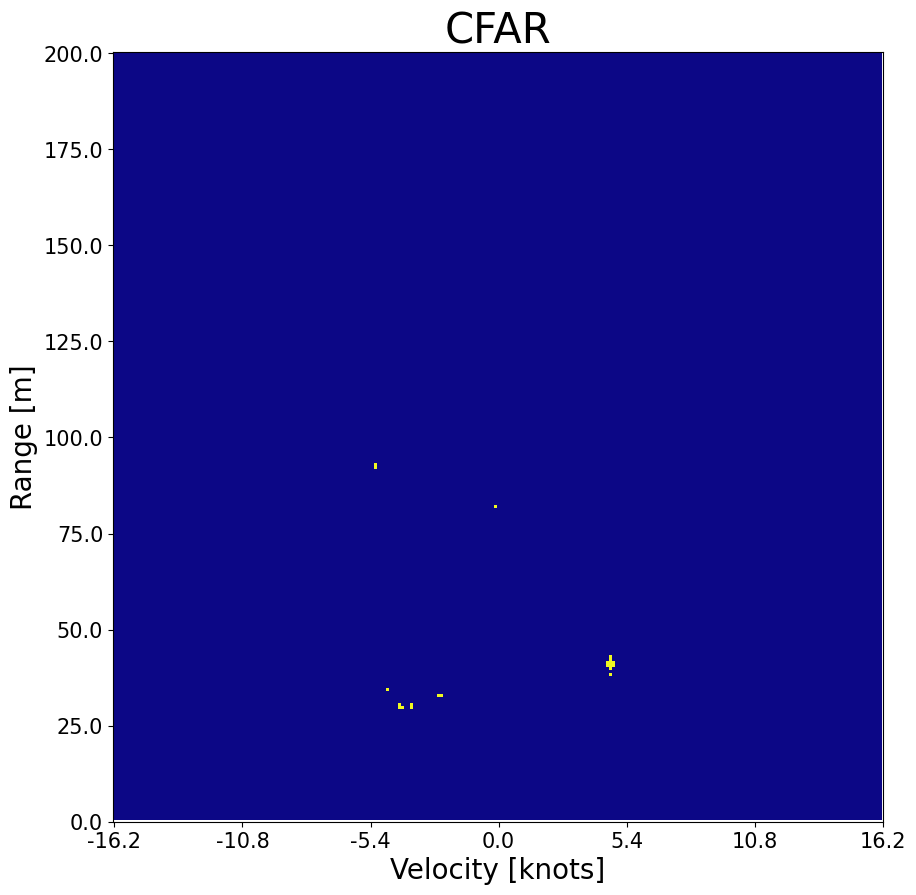

In [20]:
Plot.PlotCFAR(CFAR.CFAR_2D(doppler_map.copy(), 4, 8, 0.01))

In [21]:
import time

In [22]:
def algorithm_CA_CFAR_2D(data):
    start_time = time.time()
    range_cube =  RangeCompression.RangeCompression(data,axis=1)
    linear, mag = DopplerProcessing.DopplerProcessing(range_cube, axis=0,isClutterRemoval=True)
    #return CFAR.CA_CFAR_2D(np.abs(linear).copy())
    cfar = CFAR_1D(np.abs(linear).copy(), 4, 8, 0.01)
    print("--- %s seconds ---" % (time.time() - start_time))
    return cfar
    

    
    
            


In [212]:
def algorithm_cfar_1d(data):
    start_time = time.time()
    range_cube =  RangeCompression.RangeCompression(data,axis=1)
    linear, mag = DopplerProcessing.DopplerProcessing(range_cube, axis=0,isClutterRemoval=True)
    cfar,P = CFAR_1D(np.abs(linear).copy(), 4, 8, 0.01)
    #print("--- %s seconds ---" % (time.time() - start_time))
    return P

In [24]:
def algorithm_cfar_2d(data):
    start_time = time.time()
    range_cube =  RangeCompression.RangeCompression(data,axis=1)
    linear, mag = DopplerProcessing.DopplerProcessing(range_cube, axis=0,isClutterRemoval=True)
    cfar = CFAR.CFAR_2D(np.abs(linear).copy(), 4, 8, 0.01)
    #print("--- %s seconds ---" % (time.time() - start_time))
    return cfar

In [25]:
result_1 =algorithm_CA_CFAR_2D(data_IF[170,0])


--- 0.007869958877563477 seconds ---


In [26]:
result_2 =algorithm_cfar_1d(data_IF[170,0])


--- 0.0067980289459228516 seconds ---


In [27]:
result_3 =algorithm_cfar_2d(data_IF[170,0])

--- 0.09702491760253906 seconds ---


In [28]:
cfar_arr=[]
for i in range(50,len(data_IF)):
    cfar_arr.append(algorithm_cfar_1d(data_IF[i,0]))
    

--- 0.004417896270751953 seconds ---
--- 0.004548072814941406 seconds ---
--- 0.004094839096069336 seconds ---
--- 0.005158185958862305 seconds ---
--- 0.00518488883972168 seconds ---
--- 0.004343748092651367 seconds ---
--- 0.005073070526123047 seconds ---
--- 0.00481104850769043 seconds ---
--- 0.004541873931884766 seconds ---
--- 0.004461050033569336 seconds ---
--- 0.004163026809692383 seconds ---
--- 0.004256010055541992 seconds ---
--- 0.004478931427001953 seconds ---
--- 0.00411224365234375 seconds ---
--- 0.0041599273681640625 seconds ---
--- 0.004929065704345703 seconds ---
--- 0.004412174224853516 seconds ---
--- 0.0040471553802490234 seconds ---
--- 0.0039520263671875 seconds ---
--- 0.004307985305786133 seconds ---
--- 0.004258871078491211 seconds ---
--- 0.003996849060058594 seconds ---
--- 0.0038411617279052734 seconds ---
--- 0.0044901371002197266 seconds ---
--- 0.0042188167572021484 seconds ---
--- 0.004029989242553711 seconds ---
--- 0.004022121429443359 seconds ---
-

In [29]:
cfar_arr_CA_CFAR_2D=[]
for i in range(50,len(data_IF)):
    cfar_arr_CA_CFAR_2D.append(algorithm(data_IF[i,0]))
    

NameError: name 'algorithm' is not defined

In [ ]:
cfar_arr_CFAR_1D=[]
for i in range(50,len(data_IF)):
    cfar_arr_CFAR_1D.append(algorithm(data_IF[i,0]))

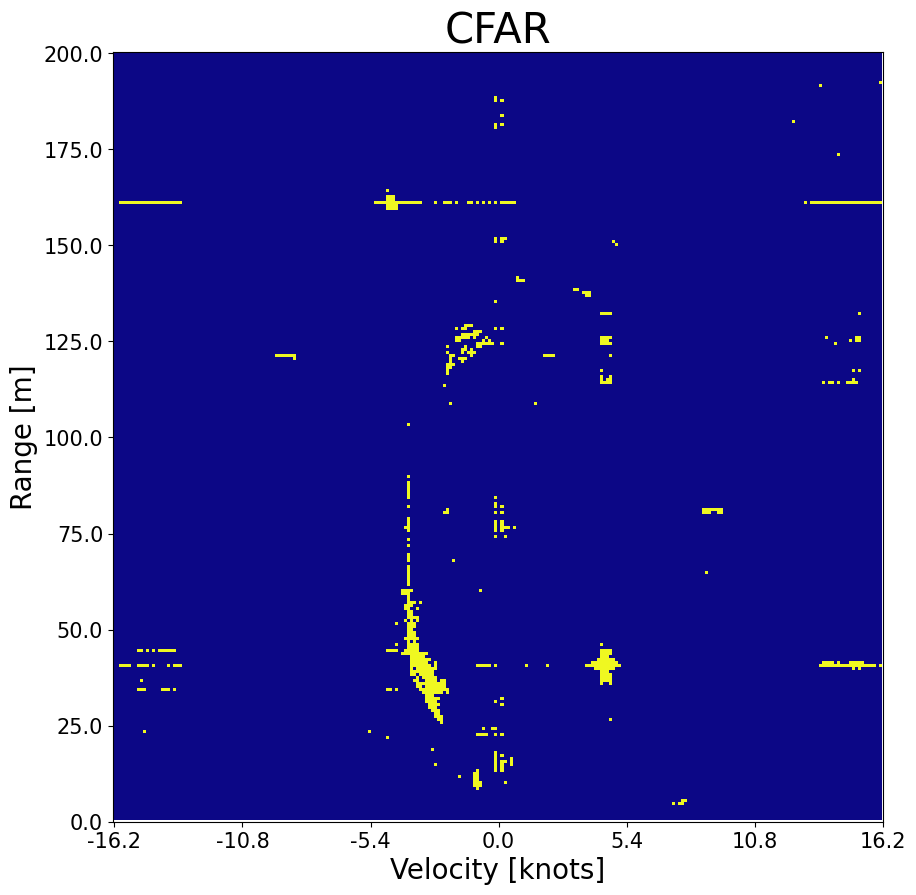

In [ ]:
Plot.PlotCFAR(np.max(cfar_arr,axis=0))

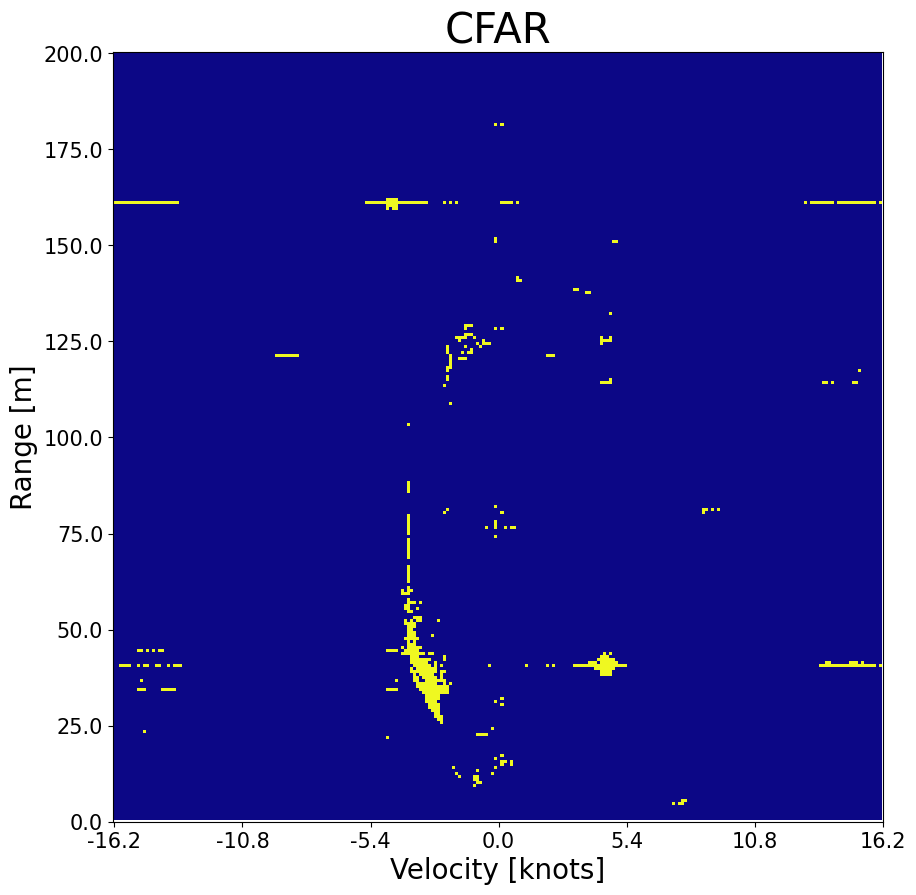

In [ ]:

Plot.PlotCFAR(np.max(cfar_arr_CA_CFAR_2D,axis=0))

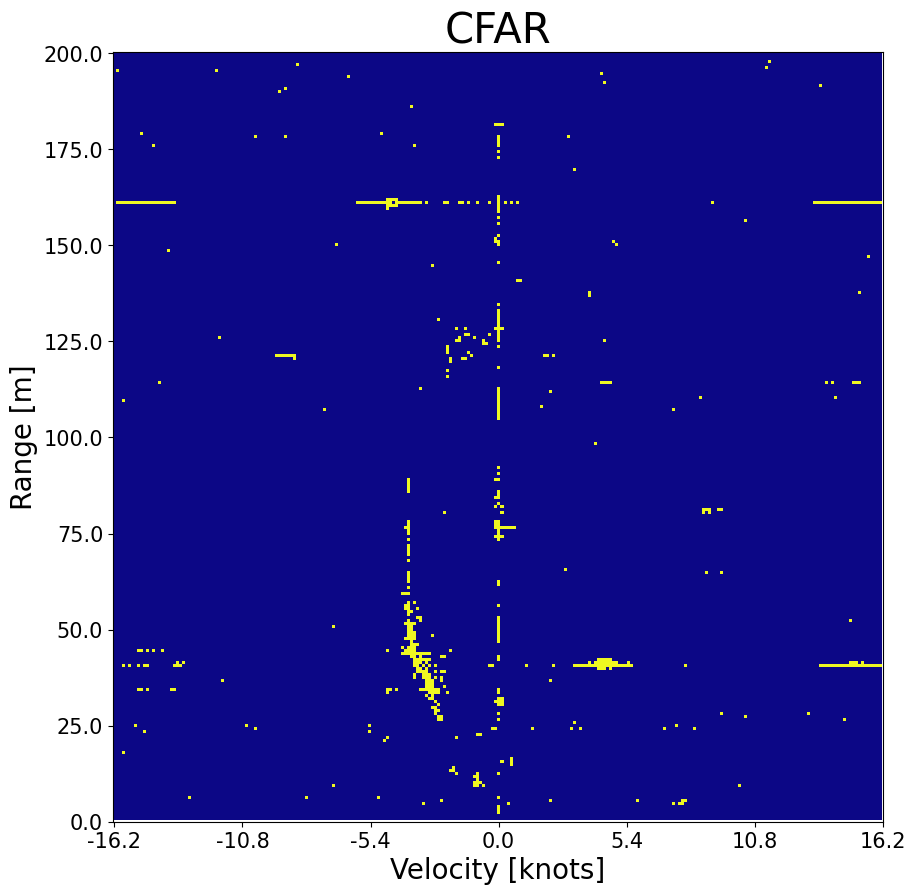

In [ ]:
Plot.PlotCFAR(np.max(cfar_arr_CFAR_1D,axis=0))

In [165]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=int(65536/2), centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

In [173]:
print(X.shape)
np.reshape(X,(256,256))

(32768, 2)


array([[ 1.25036745,  1.01102214, -1.4831804 , ...,  1.61101952,
        -0.70889133, -0.65466143],
       [ 0.3587527 , -0.45443682,  0.02342794, ...,  1.13868305,
         0.88230856,  1.66307461],
       [ 1.10764804,  0.97478578, -1.68809608, ...,  1.32264312,
        -0.20135379, -0.10592519],
       ...,
       [-1.2665537 , -0.96812413, -1.23109307, ..., -0.67062774,
        -0.90997052, -0.43228992],
       [-1.89139435, -0.17361668,  1.13992574, ...,  1.92465658,
         0.5434669 , -0.26852457],
       [-0.95999437, -0.53633177, -1.3879943 , ...,  0.84919427,
        -1.0259669 , -0.02504475]])

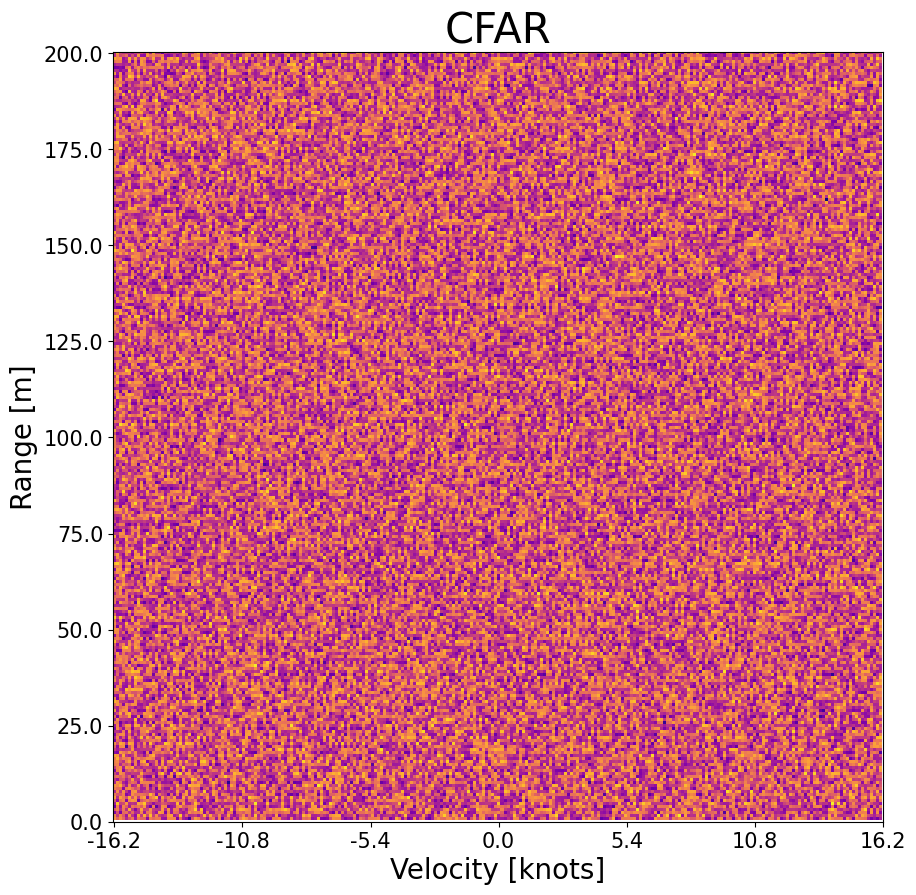

In [171]:
import matplotlib.pyplot as plt

Plot.PlotCFAR(np.reshape(X,(256,256)))

In [175]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.3, min_samples=1).fit(np.reshape(X,(256,256)))
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 0
Estimated number of noise points: 256


In [214]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

def getMeasurement(updateNumber):
    if updateNumber == 1:
      getMeasurement.currentPosition = 0
      getMeasurement.currentVelocity = 60 # m/s

    dt = 0.1

    w = 8 * np.random.randn(1)
    v = 8 * np.random.randn(1)

    z = getMeasurement.currentPosition + getMeasurement.currentVelocity*dt + v
    getMeasurement.currentPosition = z - v
    getMeasurement.currentVelocity = 60 + w
    return [z, getMeasurement.currentPosition, getMeasurement.currentVelocity]


def filter(z, updateNumber):
    dt = 0.1
    # Initialize State
    if updateNumber == 1:
        filter.x = np.array([[0],
                            [20]])
        filter.P = np.array([[5, 0],
                                 [0, 5]])
        filter.A = np.array([[1, dt],
                             [0, 1]])
        filter.H = np.array([[1, 0]])
        filter.HT = np.array([[1],
                              [0]])
        filter.R = 10
        filter.Q = np.array([[1, 0],
                             [0, 3]])
    # Predict State Forward
    x_p = filter.A.dot(filter.x)
    # Predict Covariance Forward
    P_p = filter.A.dot(filter.P).dot(filter.A.T) + filter.Q
    # Compute Kalman Gain
    S = filter.H.dot(P_p).dot(filter.HT) + filter.R
    K = P_p.dot(filter.HT)*(1/S)
    # Estimate State
    residual = z - filter.H.dot(x_p)
    filter.x = x_p + K*residual
    # Estimate Covariance
    filter.P = P_p - K.dot(filter.H).dot(P_p)
    return [filter.x[0], filter.x[1], filter.P]


def testFilter():
    dt = 0.1
    t = np.linspace(0, 10, num=300)
    numOfMeasurements = len(t)

    measTime = []
    measPos = []
    measDifPos = []
    estDifPos = []
    estPos = []
    estVel = []
    posBound3Sigma = []

    for k,dat in enumerate(data_IF):
        z = algorithm_cfar_1d(dat)
        # Call Filter and return new State
        f = filter(z, k)
        # Save off that state so that it could be plotted
        measTime.append(k)
        measPos.append(z[0])
        measDifPos.append(z[0]-z[1])
        estDifPos.append(f[0]-z[1])
        estPos.append(f[0])
        estVel.append(f[1])
        posVar = f[2]
        posBound3Sigma.append(3*np.sqrt(posVar[0][0]))

    return [measTime, measPos, estPos, estVel, measDifPos, estDifPos, posBound3Sigma];

t = testFilter()

plot1 = plt.figure(1)
plt.scatter(t[0], t[1])
plt.plot(t[0], t[2])
plt.ylabel('Position')
plt.xlabel('Time')
plt.grid(True)

plot2 = plt.figure(2)
plt.plot(t[0], t[3])
plt.ylabel('Velocity (meters/seconds)')
plt.xlabel('Update Number')
plt.title('Velocity Estimate On Each Measurement Update \n', fontweight="bold")
plt.legend(['Estimate'])
plt.grid(True)

plot3 = plt.figure(3)
plt.scatter(t[0], t[4], color = 'red')
plt.plot(t[0], t[5])
plt.legend(['Estimate', 'Measurement'])
plt.title('Position Errors On Each Measurement Update \n', fontweight="bold")
#plt.plot(t[0], t[6])
plt.ylabel('Position Error (meters)')
plt.xlabel('Update Number')
plt.grid(True)
plt.xlim([0, 300])
plt.show()

AttributeError: 'function' object has no attribute 'A'

In [1]:
import networkx as nx
G = nx.Graph()

In [10]:
G.add_node((1,{"color": "red"}))


TypeError: unhashable type: 'dict'

In [3]:
G.add_nodes_from([2, 3])

In [4]:
G.add_nodes_from([
    (4, {"color": "red"}),
    (5, {"color": "green"}),
])

In [32]:
G.add_node(G.number_of_nodes()+1)

In [11]:
print(G.nodes[5]["color"])

green


In [30]:
import networkx as nx

# create a DAG
G = nx.DiGraph()
G.add_edges_from([(1, 2), (1, 3), (2, 4), (2, 5), (3, 6)])

# get the leaf nodes
leaf_nodes = set()
all_nodes = set(G.nodes())

for node in all_nodes:
    descendants = nx.descendants(G, node)
    if not descendants:
        leaf_nodes.add(node)

print(G.nodes)

[1, 2, 3, 4, 5, 6]


In [25]:
G.graph

{}